In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd


mpl.rcParams['figure.dpi'] = 100

In [2]:
from utils.corpus import Corpus

corpus = Corpus(registry_path='../utils/article_registry.json')
corpusList = corpus.get_documents_list()

In [4]:
n_topics = 70
MODELPATH = f'models/{n_topics}_topics/LDA_gensim_{n_topics}.model'

print(MODELPATH)

models/70_topics/LDA_gensim_70.model


In [5]:
from utils.exploration import get_articles_in_topic, get_titles_in_topic
from utils.exploration import get_keywords_in_topic, summary
from utils.exploration import summarize_topic, topic_top_n

Creating ../data/articles_in_topics.json


In [6]:
from gensim.models.ldamodel import LdaModel

lda = LdaModel.load(MODELPATH)
#lda = LdaModel.load("LDA_gensim_90_final.model")

In [7]:
!rm topics_{n_topics}.md

with open(f'topics_{n_topics}.md', 'a') as fp:
    for t in range(n_topics):
       
        num_articles = len(get_articles_in_topic(t, min_prob=0.5))
        
        if num_articles < 5:
            continue
            
        fp.write(f'\n# Topic {t}\n\n')
        fp.write(f'## Articles in topic: {num_articles}\n')
        
        
        fp.write('## Topic word probabilities:\n')
        fp.write('| Word | Probability |\n')
        fp.write('|---|---|\n')

        for word in topic_top_n(lda, t, n=20):

            fp.write(f"| {word[0]} | {word[1]} | \n")
            
        
        fp.write('\n## Top articles:\n')
            
        articles = get_articles_in_topic(t, min_prob=0.5, n=5)
        
        for article, _ in articles:
            try:
                year = datetime.datetime.strptime(article.date, "%Y/%m/%d").year
            except:
                year = article.date
                
            fp.write(f"* {article.author} ({year}). {article.title} [{article.id}]\n")

        fp.write('\n\\newpage')
        
!pandoc "topics_{n_topics}.md" -o topics_{n_topics}.pdf --pdf-engine=xelatex

---

In [8]:
years = []
for topic in range(90):
    years +=[{'topic': topic, 'year': article[0].year, 'id':article[0].id} for article in get_articles_in_topic(topic, min_prob=0.5)]

In [9]:
df = pd.DataFrame(years)

In [10]:
df['year'] = df['year'].astype(int)
df['year'] = pd.cut(df['year'], bins = [x for x in range(1950, 2021, 5)])


In [11]:
yearProgression = df.groupby(['year', 'topic']).count().unstack()
yearProgression.fillna(0, inplace = True)

In [12]:
yearProgression.columns = [index[1] for index in yearProgression.columns]

In [13]:
yearProgression = yearProgression[yearProgression.columns[yearProgression.sum()>=10]]

In [14]:
#per = yearProgression.apply(lambda x: x / x.sum() * 100, axis = 1).fillna(0)
per = yearProgression

per['end'] = [x.right for x in per.index]

per.set_index('end', inplace = True)

per = per[per.index > 1970]

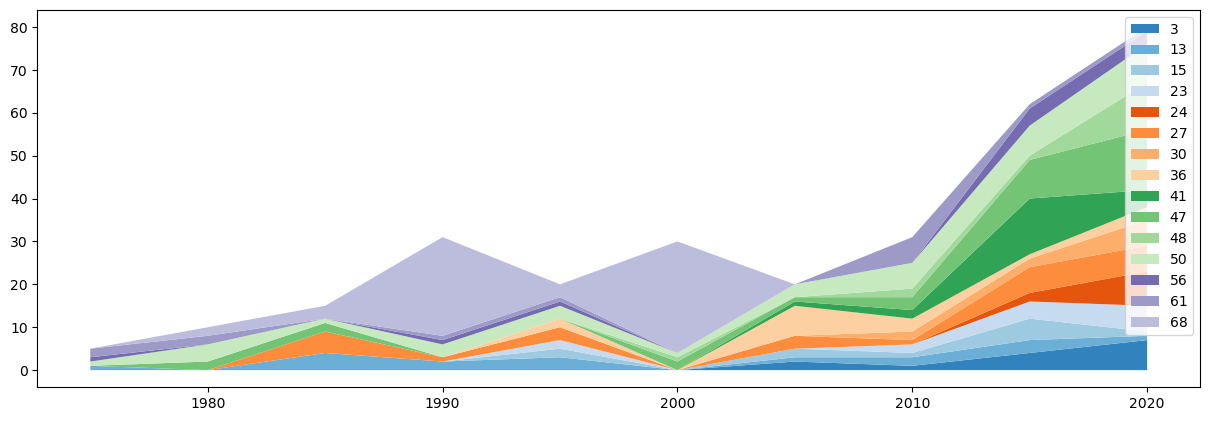

In [15]:
fig = plt.figure(figsize=(15,5))

from cycler import cycler 

colors = plt.cm.tab20c.colors

plt.gca().set_prop_cycle(cycler('color', colors))

base = 0
c = 0.01
for topic in per.iteritems():
    data = topic[1]
    
    plt.fill_between(per.index, y1 = base, y2 = base + data, label = topic[0])
    
    base += data
    c += 0.08
    
plt.legend()

---

In [16]:
with open('../data/gridsearch.json') as fp:
    grid = pd.read_json(fp.read())

In [17]:
from collections import defaultdict

data = []
for n_topics in grid:
    for iteration in grid[n_topics]:
        grid_df = defaultdict()

        grid_df['num_topics'] = n_topics
        
        grid_df['coherence'] = iteration['coherence']

        for key, value in iteration['n_articles_per_topic'].items():
            if key == '-1':
                grid_df['orphans'] = value
                
        n_docs_topic = [x for k, x in iteration['n_articles_per_topic'].items() if k != '-1']
        
        grid_df['num_classified_docs'] = sum(n_docs_topic)
        
        grid_df['avg_num_docs'] = np.mean(n_docs_topic)
        grid_df['std_num_docs'] = np.std(n_docs_topic)

        grid_df['max_docs_topic'] = np.max(n_docs_topic)
        grid_df['min_docs_topic'] = np.min(n_docs_topic)

        grid_df['useful_topics'] = len([x for x in n_docs_topic if x >= 5])
        
        #grid_df['classified_docs'] = sum(n_docs_topic)
        
        data.append(grid_df)
        
grid_df = pd.DataFrame(data)

In [18]:
grid_df

,num_topics,coherence,num_classified_docs,avg_num_docs,std_num_docs,max_docs_topic,min_docs_topic,useful_topics,orphans
0,80,0.407344,825,12.313433,23.565855,162,1,32,NaN
1,80,0.415617,825,12.692308,31.559430,154,1,19,NaN
2,80,0.404417,825,12.890625,30.441602,198,1,23,NaN
3,90,0.403966,825,12.500000,26.644261,140,1,20,NaN
4,90,0.414250,825,12.500000,31.992068,221,1,27,NaN
5,90,0.392433,825,12.890625,54.998613,445,1,24,NaN
6,100,0.415122,816,11.178082,23.866261,147,1,28,9.0
7,100,0.406181,816,10.736842,22.071873,133,1,29,9.0
8,100,0.414226,816,10.329114,24.880332,188,1,29,9.0
9,110,0.430749,816,9.714286,20.316877,109,1,28,9.0


Text(0.5, 0, 'Num. of topics in model')

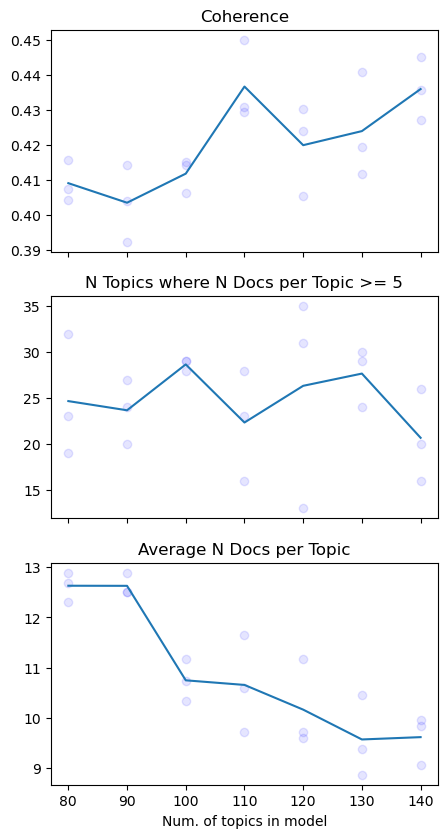

In [19]:
fig, axes = plt.subplots(3, 1, sharex = True, figsize = (5, 10))

data = grid_df.groupby('num_topics')

plot_counter = 0

labels = {'coherence': 'Coherence',
         'useful_topics': 'N Topics where N Docs per Topic >= 5',
         'avg_num_docs': 'Average N Docs per Topic'}

for metric in ['coherence', 'useful_topics', 'avg_num_docs']:
       
    mins = data[metric].min()
    maxs = data[metric].max()
    avgs = data[metric].mean()

    axes[plot_counter].plot(avgs.index, avgs)
    #axes[plot_counter].fill_between(mins.index, mins, maxs, alpha = 0.1)
    axes[plot_counter].set_title(labels[metric])
    
    axes[plot_counter].scatter(grid_df['num_topics'], grid_df[metric], color = 'Blue', alpha = 0.1)

    plot_counter += 1

plt.xlabel('Num. of topics in model')

In [20]:
axes

array([<AxesSubplot:title={'center':'Coherence'}>,
       <AxesSubplot:title={'center':'N Topics where N Docs per Topic >= 5'}>,
       <AxesSubplot:title={'center':'Average N Docs per Topic'}, xlabel='Num. of topics in model'>],
      dtype=object)

---

In [21]:
mpl.use("pgf")
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

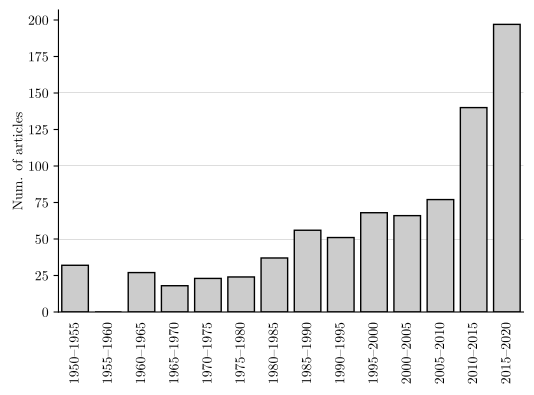

In [22]:
yearsCount = [int(x.year) for x in corpusList]
yearsCount = pd.cut(yearsCount, [x for x in range(1950, 2021, 5)])

ax = sns.barplot(x = yearsCount.categories, y = yearsCount.value_counts(), fc = "#ccc", ec = 'Black')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    
plt.ylabel('Num. of articles')

xpos, xTicks = plt.xticks()

newTicks = []
for tick in xTicks:
    pair = tick.get_text()
    newPair = f"{pair[1:5]}\u2013{pair[7:11]}"
    newTicks.append(newPair)
    
_ = plt.xticks(xpos, newTicks, rotation=90)
plt.tick_params(bottom=False)

for x in range(0, 200, 50):
    ax.axhline(x, color = '#ddd', zorder = 0, lw = 0.5)

plt.savefig('fig1.pgf', bbox_inches = 'tight')

In [23]:
wordCounts = pd.Series([len(x.bagOfWords.split()) for x in corpusList if len(x.bagOfWords) > 0])
print(wordCounts.describe())

words = []
for doc in corpusList:
    words += list(set(doc.bagOfWords.split()))

print(f"Total number of words (usable): {len(words)}")

count      816.000000
mean      3342.018382
std       1689.169559
min         36.000000
25%       2300.750000
50%       3325.000000
75%       4352.750000
max      11930.000000
dtype: float64
Total number of words (usable): 1030016


In [24]:
wordCounts = pd.Series([len(x.text.split()) for x in corpusList if len(x.bagOfWords) > 0])
print(wordCounts.describe())

words = []
for doc in corpusList:
    words += list(set(doc.text.split()))

print(f"Total number of words (total): {len(words)}")

count      816.000000
mean      8506.682598
std       4598.993232
min          3.000000
25%       5919.250000
50%       8454.500000
75%      10835.250000
max      32901.000000
dtype: float64
Total number of words (total): 1953167


In [25]:
from collections import defaultdict
data = []
for doc in corpusList:
    
    if int(doc.year) < 1985:
        continue
        
    row = defaultdict()
    row['id'] = doc.id
    row['year'] = doc.year
    row['length'] = len(doc.bagOfWords.split())
    
    data.append(row)
    
words_df = pd.DataFrame(data)

In [26]:
words_df = words_df.groupby('year').mean()

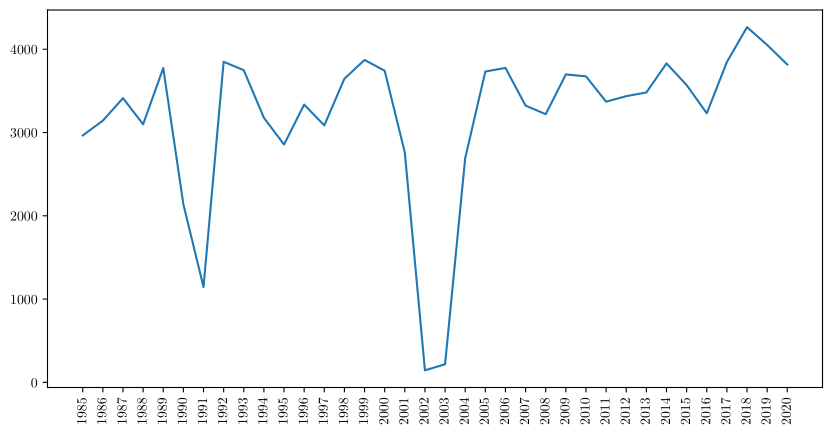

In [27]:
plt.figure(figsize = (10, 5))
plt.plot(words_df.index, words_df['length'])
_ = plt.xticks(rotation = 90)

In [28]:
[f"{x.title} [{x.id}]: {len(x.bagOfWords.split())}" for x in corpusList if x.year == '2002']

['Sepúlveda: traductor y comentarista de Aristóteles, Política I [16327]: 145',
 'Arbitrariedad y posibilidad de alteración de lenguajes en Wittgenstein [16342]: 195',
 'Una tensa cercanía: Hegel, Gadamer y el concepto de experiencia. [14538]: 255',
 'Sensus Communis: de la imaginación en Vico a la tradición en Gadamer [14558]: 126',
 'El oído hermenéutico [14535]: 71',
 'Racionalidad y autodeterminación [16339]: 94',
 'La justificación biológica de la moral: modelos y perspectivas [16340]: 112',
 'La ciencia llama a juicio a la filosofía. Expediente: índices de conmensurabilidad [16341]: 196',
 'La Política de Aristóteles y el aristotelismo político de la conquista [16326]: 303',
 'Ser y poder ser en la metafísica de José Aguilar. Posibilidad en el "Curso de filosofía dictado en Lima" [16322]: 180',
 'La cosmografía de Suárez de Urbina [16323]: 177',
 'La lógica modal en Tomás de Mercado [16321]: 88',
 'Comprensión y pertenencia [14520]: 57',
 'H.-G. Gadamer y los once profesores de u

---

In [38]:
np.max([int(x.year) for x in corpusList if x.format == 'HTML'])

2017